In [160]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl

### Function to parse through *differential expression* CSV files and returns:
1. Gene Symbols
1. log2FC
1.  B-H adjusted p-value for different microarray platforms

For each microarray experiment - iterate through each row (e.g. probe), find corresponding gene symbol (if one exists) and return corresponding log2FC & adjusted p-val

In [113]:
def extract_gene_logFC_pval_from_diff_exp_csv(microarray_diff_exp_data_filepath_i):
    
    '''
    input: path to differential expression CSV file
    '''

    diff_exp_data_df = pd.read_csv(microarray_diff_exp_data_filepath_i) #load dataframe from csv file

    gene_symbols_list_microarray_i = [] 
    logFC_list_microarray_i = []
    pval_list_microarray_i = []

    microarray_platform = microarray_platform_dict[microarray_diff_exp_data_filepath_i.split('/')[-1].split('.')[0]]

    if (microarray_platform == 'GPL6947') or (microarray_platform == 'GPL4133') or (microarray_platform == 'GPL10558') or (microarray_platform == 'GPL570') or (microarray_platform == 'GPL11532'):
                
        diff_exp_data_df = diff_exp_data_df.loc[: , ['Gene.symbol' , 'logFC' , 'adj.P.Val']] #subset to relevant columns

        for row_i in diff_exp_data_df.index:

            gene_symbol_i , logFC_i , pval_i = diff_exp_data_df.loc[row_i , :]

            #multiple genes, store logFC & pval for each gene
            if (type(gene_symbol_i) == str) and ('///' in gene_symbol_i) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                for gene_symbol_i in list(set([gene for gene in gene_symbol_i.split('///')])):                                
                    gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                    logFC_list_microarray_i.append(logFC_i)
                    pval_list_microarray_i.append(pval_i)

            #one gene, if gene symbol exists, and logFC/pval exist, store data
            elif (type(gene_symbol_i) == str) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                logFC_list_microarray_i.append(logFC_i)
                pval_list_microarray_i.append(pval_i)
                
    elif (microarray_platform == 'GPL5175'):

        diff_exp_data_df = diff_exp_data_df.loc[: , ['gene_assignment' , 'logFC' , 'adj.P.Val']]

        for row_i in diff_exp_data_df.index:

            gene_assignment_i , logFC_i , pval_i = diff_exp_data_df.loc[row_i , :]

            #multiple genes, store logFC & pval for each gene
            if (type(gene_assignment_i) == str) and ('///' in gene_assignment_i) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                for gene_symbol_i in list(set([gene_info.split('//')[1] for gene_info in gene_assignment_i.split('///')])):                                
                    gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                    logFC_list_microarray_i.append(logFC_i)
                    pval_list_microarray_i.append(pval_i)

            #one gene
            elif (type(gene_assignment_i) == str) and ('//' in gene_assignment_i) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                gene_symbol_i = gene_assignment_i.split('//')[1]
                gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                logFC_list_microarray_i.append(logFC_i)
                pval_list_microarray_i.append(pval_i)

    elif (microarray_platform == 'GPL16951'):

        diff_exp_data_df = diff_exp_data_df.loc[: , ['Gene_symbol' , 'logFC' , 'adj.P.Val']]

        for row_i in diff_exp_data_df.index:

            gene_symbol_i , logFC_i , pval_i = diff_exp_data_df.loc[row_i , :]

            #multiple genes
            if (gene_symbol_i != 'previous version conserved probe') and (type(gene_symbol_i) == str) and ('|' in gene_symbol_i) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                for gene_symbol_i in list(set([gene for gene in gene_symbol_i.split('|')])):                                
                    gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                    logFC_list_microarray_i.append(logFC_i)
                    pval_list_microarray_i.append(pval_i)

            #one gene
            elif (gene_symbol_i != 'previous version conserved probe') and (type(gene_symbol_i) == str) and (np.isnan(logFC_i) == False) and (np.isnan(pval_i) == False):
                gene_symbols_list_microarray_i.append(gene_symbol_i.strip())
                logFC_list_microarray_i.append(logFC_i)
                pval_list_microarray_i.append(pval_i)

    gene_logFC_pval_df = pd.DataFrame()
    gene_logFC_pval_df['gene'] = gene_symbols_list_microarray_i
    gene_logFC_pval_df['logFC'] = logFC_list_microarray_i
    gene_logFC_pval_df['pval'] = pval_list_microarray_i
    
    #set index to gene symbol
    gene_logFC_pval_df.set_index('gene' , inplace = True , drop = True)

    return gene_logFC_pval_df

### Function to parse through *processed differential expression* dataframes (gene symbols-logFC-pval) and return series with genes & logFC that have:

1. $|\log_2(FC)| > 0$ which corresponds to $|FC| > 1$
1. $\text{BH adjusted pval} \le 0.05$
1. If a gene has multiple rows (e.g. probes) that fit criteria for (1) and (2), report mean $\log_2(FC)$ for all rows with $\text{BH adj. pval} \le 0.05$

In [114]:
#set thresholds for logFC & pval
logFC_thresh = 0.0
pval_thresh = 0.05

In [132]:
def extract_significant_gene_logFC(gene_logFC_pval_df, analysis_ID):

    #get dictionary that counts the instances of each gene in this data (most will coorespond to 1 row)
    num_rows_per_gene_dict = Counter(gene_logFC_pval_df.index) #keys:unique genes, values:number of rows w/ logFC
    logFC_series = pd.Series(index = list(num_rows_per_gene_dict.keys()), name = analysis_ID) #empty series that stores logFC or NaN for each gene

    #iterate through each gene, check if logFC & pval pass thresholds
    for gene_i in logFC_series.index:

        #one logFC measurement for gene
        if num_rows_per_gene_dict[gene_i] == 1:

            logFC_i , pval_i = gene_logFC_pval_df.loc[gene_i , :]

            if (abs(logFC_i) > logFC_thresh) and (pval_i <= pval_thresh): #gene exp measurement meets thresholds
                logFC_series[gene_i] = logFC_i
            else:
                logFC_series[gene_i] = np.nan

        #multiple logFC measurements for gene
        elif num_rows_per_gene_dict[gene_i] > 1:

            valid_logFC_meas = [] #list of valid logFC measurements that meet thresholds
            for logFC_i , pval_i in zip(gene_logFC_pval_df.loc[gene_i , 'logFC'], gene_logFC_pval_df.loc[gene_i , 'pval']):

                if (abs(logFC_i) > logFC_thresh) and (pval_i <= pval_thresh):
                    valid_logFC_meas.append(logFC_i)

            if len(valid_logFC_meas) == 1: #one valid logFC measurement
                logFC_series[gene_i] = valid_logFC_meas[0]
            elif len(valid_logFC_meas) > 1: #multiple valid logFC measurements
                logFC_series[gene_i] = np.mean(valid_logFC_meas)
            elif len(valid_logFC_meas) == 0:
                logFC_series[gene_i] = np.nan
                
    return logFC_series

# ATB vs LTBI 

### Directory where the Differential Gene Expression Data is stored

In [116]:
microarray_diff_exp_data = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Microarray Differential Gene Expression/ATB_v_LTBI/"

#seperate differential gene expression files from different studies
microarray_diff_exp_data_files = [
'GSE19439.csv', 
'GSE19442.csv', 
'GSE19444.csv', 
'GSE28623.csv', 
'GSE37250.csv', 
'GSE39939.csv', 
'GSE39940.csv', 
'GSE41055.csv', 
'GSE54992.csv', 
'GSE62525.csv', 
'GSE69581.csv', 
'GSE73408.csv']

Mapping of microarray platform used for each study

In [118]:
microarray_platform_dict = {
'GSE19439':'GPL6947',
'GSE19442':'GPL6947',
'GSE19444':'GPL6947',
'GSE28623':'GPL4133',
'GSE37250':'GPL10558',
'GSE39939':'GPL10558',
'GSE39940':'GPL10558',
'GSE41055':'GPL5175',
'GSE54992':'GPL570',
'GSE62525':'GPL16951',
'GSE69581':'GPL10558',
'GSE73408':'GPL11532'}

### Extract significant logFC measurements from each differential gene expression analysis

In [148]:
#construct a dictionary to hold the logFC series for each analysis
sig_gene_logFC_per_experiment_dict = {}

for microarray_diff_exp_data_file_i in microarray_diff_exp_data_files:
    
    analysis_ID = microarray_diff_exp_data_file_i.split('.')[0]
    print('processing file {0}'.format(analysis_ID))

    #get logFC & pvals for all genes (and all probes) from diff gene exp experiment
    gene_logFC_pval_df = extract_gene_logFC_pval_from_diff_exp_csv(microarray_diff_exp_data + microarray_diff_exp_data_file_i)

    #filter for significant genes (with logFC > logFC_thresh, pval >= pval_thresh, ensure 1 gene measurement per analysis/experiment)
    logFC_series = extract_significant_gene_logFC(gene_logFC_pval_df, analysis_ID)
    
    #store significant logFC per gene in dict
    sig_gene_logFC_per_experiment_dict[analysis_ID] = logFC_series

processing file GSE19439


//anaconda3/envs/py37_and_R_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


processing file GSE19442
processing file GSE19444
processing file GSE28623
processing file GSE37250
processing file GSE39939
processing file GSE39940
processing file GSE41055
processing file GSE54992
processing file GSE62525
processing file GSE69581
processing file GSE73408


#### Create DataFrame to store all of the significant logFC changes across all analyses

In [149]:
#construct a set of non-redundant genes across all studies for index of DataFrame
unique_genes = set([])
for analysis_ID in sig_gene_logFC_per_experiment_dict.keys():
    gene_set_i = set(sig_gene_logFC_per_experiment_dict[analysis_ID].index) #genes analyzed in experiment
    
    unique_genes = unique_genes.union(gene_set_i) #append to set of genes
unique_genes = list(unique_genes) #convert to list

#create DataFrame
ATB_v_LTBI_diff_gene_exp_df = pd.DataFrame(index = unique_genes)

#iterate over logFC series from each differential gene expression analysis and fill DataFrame
for analysis_ID in sig_gene_logFC_per_experiment_dict.keys():
    
    #merge the series holding the logFC values from a specific dataset to the master dataframe with the significant logFC values from all datasets
    ATB_v_LTBI_diff_gene_exp_df = ATB_v_LTBI_diff_gene_exp_df.join(sig_gene_logFC_per_experiment_dict[analysis_ID])

In [150]:
ATB_v_LTBI_diff_gene_exp_df

,GSE19439,GSE19442,GSE19444,GSE28623,GSE37250,GSE39939,GSE39940,GSE41055,GSE54992,GSE62525,GSE69581,GSE73408
FLJ14107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C19orf66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.689700,NaN,NaN,NaN
C1orf110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATG16L2,NaN,NaN,NaN,NaN,0.193723,NaN,0.248379,NaN,2.041483,0.820285,NaN,0.182867
OTUD7B,NaN,NaN,NaN,-0.908799,NaN,NaN,NaN,NaN,-0.909218,NaN,NaN,-0.249904
...,...,...,...,...,...,...,...,...,...,...,...,...
UBE3B,NaN,NaN,NaN,NaN,0.165979,NaN,0.258091,NaN,NaN,0.632196,NaN,NaN
USP46,NaN,NaN,NaN,NaN,-0.642154,NaN,NaN,NaN,NaN,-0.422687,NaN,-0.263100
ABCB1,NaN,-1.110657,-1.081071,-0.842451,-0.656135,-0.672848,-0.654646,NaN,-2.077512,-0.601625,-1.417709,-0.651265
BLOC1S2,NaN,NaN,NaN,NaN,0.514037,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Output DataFrame as a CSV

In [156]:
ATB_v_LTBI_diff_gene_exp_df.to_csv(microarray_diff_exp_data + 'signif_logFC_across_studies.csv')

#### Across how many datasets was each gene *significantly* differentially expressed in?

In [157]:
num_datasets_diff_exp_per_gene = pd.Series(index = ATB_v_LTBI_diff_gene_exp_df.index)

#iterate through each gene
for gene_i in num_datasets_diff_exp_per_gene.index:
    
    #boolean filter for specific gene that is TRUE is gene was significantly differentially expressed in study & FALSE otherwise
    signif_diff_exp_filter = [not nan_val for nan_val in pd.isna(ATB_v_LTBI_diff_gene_exp_df.loc[gene_i , :])]
    num_datasets_diff_exp_per_gene[gene_i] = np.sum(signif_diff_exp_filter)

//anaconda3/envs/py37_and_R_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [178]:
num_datasets_diff_exp_per_gene.sort_values(ascending = False).head(n = 40)

FLVCR2      11.0
MSRB2       11.0
IFITM3      11.0
HP          11.0
FCGR1B      11.0
ID3         11.0
TNFSF10     11.0
JAK2        11.0
C20orf24    11.0
PASK        11.0
SORT1       11.0
DUSP3       11.0
BATF2       11.0
TXN         11.0
ABLIM1      11.0
ADM         11.0
CCR6        11.0
EPHA4       11.0
FBXO6       11.0
SAMD9L      11.0
RAB24       11.0
CEACAM1     11.0
TNFRSF25    11.0
UBE2L6      11.0
SMARCD3     11.0
TDRD9       11.0
DRAM1       11.0
SERPING1    11.0
VAMP5       11.0
IL7R        11.0
C5          11.0
GRAP        11.0
GPR183      11.0
S1PR1       11.0
LHFPL2      11.0
C1QB        11.0
ETV7        11.0
FOXO1       10.0
ATG3        10.0
CD14        10.0
dtype: float64

In [164]:
np.max(num_datasets_diff_exp_per_gene)

11.0

In [169]:
np.min(num_datasets_diff_exp_per_gene)

0.0

In [161]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

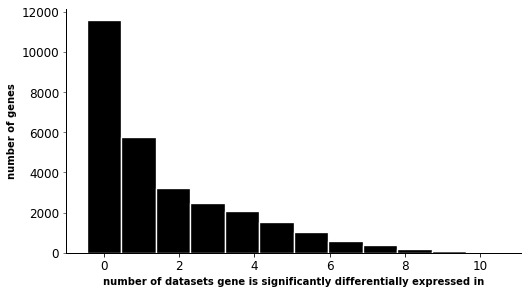

In [173]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(num_datasets_diff_exp_per_gene , bins = 12 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.35 , align = 'left')

plt.xlabel('number of datasets gene is significantly differentially expressed in', fontweight = 'bold' , fontsize = 10, color = 'k')
plt.ylabel('number of genes', fontweight = 'bold' , fontsize = 10, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 4.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/home/rv76/Farhat_Lab/Figures/Final_5/Scraping_rollingDB/Mean_Coverage_Distribution_across_all_isolates.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

How many genes were found to be significantly differentially expressed in at least 9 datasets?

In [190]:
len(num_datasets_diff_exp_per_gene[num_datasets_diff_exp_per_gene >= 9])

344

Which genes were they? Plug this gene set into **enrichr**

In [191]:
for gene in num_datasets_diff_exp_per_gene[num_datasets_diff_exp_per_gene >= 9].index:
    print(gene)

IFITM2
TLR5
CCR2
SECTM1
IL32
P2RY10
S1PR1
PBX4
CR1
HCAR3
TLR8
FAM159A
BST1
RNF213
HIST1H3D
SNX10
ZFP82
DDX31
MCEMP1
UBE2L6
LY9
SMARCD3
HIST1H2BK
ZNF548
SAT1
VPS9D1
CD6
C1QC
GBP6
LCN2
BAZ1A
FAM102A
ATP8B2
TDRD9
C3AR1
TSHZ3
MICU1
C5
MSRB2
KIF1B
FOXO1
POMP
SCO2
IRAK3
IL23A
DEFA3
TAP1
SLC2A3
CNIH4
SH3GLB1
CLYBL
NPAT
FLVCR2
ARL14EP
C12orf29
IFITM1
ITGAM
DYNLT1
RNF135
SLC38A1
CREB5
MLLT6
TYMP
LILRA5
CSAD
SEPT6
H2AFJ
RAB32
VAMP5
C1QB
DHRS3
RORA
ETS1
PLBD1
PYCARD
BCL11B
OPLAH
FAM198B
NELL2
LTBR
PSMB8
AIM2
RIOK1
SLC4A7
IFI30
AK4
AGMAT
SQRDL
TCF7
LRRK2
PLEKHB1
SKAP1
NR3C2
KLF12
RFTN1
ZNF529
FAM129C
ASGR2
TEX10
SEPT4
SLC6A12
PHTF1
TIMM10
TCN1
LCMT2
EXOSC10
ATP6V0E2
MTF1
PSMB9
CHMP5
DPYD
CD274
IL7R
C2
HP
PLAUR
CYB5R4
KMT2A
CIRBP
ASPHD2
B4GALT5
FCRLA
ANKRD22
SFI1
CA5B
CHMP2A
KIAA1147
GBA
ADM
PILRA
TMEM140
HIST2H2AC
CNNM3
CD40LG
TXN
SLC22A4
ANKRD46
PITPNC1
TMEM160
CD79A
CASP4
TRIM6
SLC7A6
RNF149
SOD2
NAIP
EMILIN2
CAMP
BCL6
ATM
AGTRAP
MS4A6A
TRIB2
GAS6
ADARB1
ZNF329
LHFPL2
NMT2
TMEM156
IL1B
CSNK1E
TP

Results from plugging in 344 genes into https://amp.pharm.mssm.edu/Enrichr/

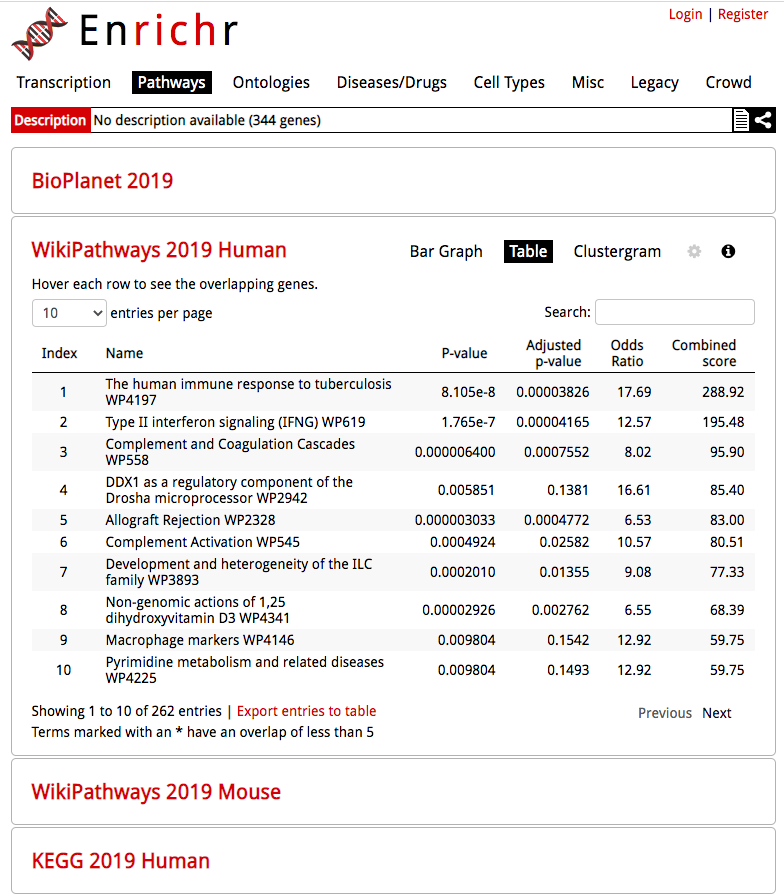

In [192]:
from IPython.display import Image
Image(filename = microarray_diff_exp_data + "enrichr_results_344_genes.png", width=600, height=900)